In [4]:
import librosa
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
from collections import deque

SAMPLE_RATE = 22050
HOP_LENGTH = 256
CHANNELS = 1
N_FFT = 512
feature_rate = int(SAMPLE_RATE / HOP_LENGTH)

In [5]:
class StreamProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, chunk_size=1024, verbose=True):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.verbose = verbose
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.chroma_buffer = queue.Queue()
        self.last_chunk = None
        self.is_mic_open = False
        self.index = 0

    def _process_frame(self, data, frame_count, time_info, status_flag):
        print(f'\nprocess_frame index: {self.index}')
        if self.verbose:
            print(f"{self.index}st time_info: {time_info}")
            # print(f"get_time: {self.audio_stream.get_time()}")
            # print(f"{self.index}st frame has arrived: {time.time()}")

        self.buffer.put(data)

        query_audio = np.frombuffer(data, dtype=np.float32)
        # print(f"query_audio: min({np.min(query_audio)}) ~ max({np.max(query_audio)})")
        query_chroma_stft = librosa.feature.chroma_stft(
            y=query_audio, hop_length=HOP_LENGTH, n_fft=N_FFT
        )
        if self.last_chunk is None:  # first audio chunk is given
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"],
                "chroma_stft": query_chroma_stft[:, :-1],
            }
            self.chroma_buffer.put(current_chunk)
            # self.chroma_buffer.put(query_chroma_stft[:, :-1])  # pop last frame converted with zero padding
        else:
            override_previous_padding = librosa.feature.chroma_stft(
                y=np.concatenate((self.last_chunk, query_audio[:HOP_LENGTH])),
                sr=self.sample_rate,
                hop_length=HOP_LENGTH,
                n_fft=N_FFT,
            )[:, 1:-1]  # drop first and last frame converted with zero padding
            accumulated_chroma = np.concatenate((override_previous_padding, query_chroma_stft[:, 1:-1]), axis=1)
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"] + HOP_LENGTH / SAMPLE_RATE,
                "chroma_stft": accumulated_chroma,
            }
            self.chroma_buffer.put(current_chunk)
        print(f"[PUT] for {self.index}st frame")
        print(f"queue inside at {self.index}: {self.chroma_buffer.qsize()}")
        self.last_chunk = query_audio[query_audio.shape[0] - HOP_LENGTH:]
        self.index += 1
        return (data, pyaudio.paContinue)

    def run(self):
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._process_frame,
        )
        self.is_mic_open = True
        self.audio_stream.start_stream()
        self.start_time = self.audio_stream.get_time()
        print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")

In [4]:
RECORD_SECONDS = 3
CHUNK_SIZE = 2048

chunks = np.array([])
query_chroma_stft = np.array([])

ref_audio, ref_sr = librosa.load("../resources/audio/target/Haydn_Hob.XVI34_1-1.wav")
ref_chroma_stft = librosa.feature.chroma_stft(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
cost_matrix = None
step_index_matrix = None
warping_path = None
chroma_first_stft = None

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
sp.run()

start = time.time()
# for _ in range(int(SAMPLE_RATE / CHUNK_SIZE * RECORD_SECONDS)):
for _ in range(1):
    latest_chunk = sp.chroma_buffer.get()  # (12, 8)
    print(f"latest chunk: {latest_chunk['timestamp'], latest_chunk['chroma_stft'].shape}")
    break

sp.stop()

* Recording in progress....

process_frame index: 0
0st time_info: {'input_buffer_adc_time': 1467210.449213218, 'current_time': 1467210.545084208, 'output_buffer_dac_time': 0.0}


/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/imp/lib/python3.9/site-packages/librosa/core/pitch.py:338: RuntimeWarning: overflow encountered in multiply
  dskew = 0.5 * avg * shift


ParameterError: Input must be finite

RuntimeError: release unlocked lock

In [ ]:
np.min(ref_audio), np.max(ref_audio)

In [ ]:
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw

wp = sync_via_mrmsdtw(f_chroma1=ref_chroma_stft[:, :8],
                    f_chroma2=chroma_first_stft,
                    input_feature_rate=feature_rate,
                    verbose=True)

### DTW Section

In [ ]:
# librosa test

RECORD_SECONDS = 11
CHUNK_SIZE = 1024
WINSIZE = 120 # 120 * 256 / 22050 seconds

chunks = np.array([])

ref_audio, ref_sr = librosa.load("../resources/audio/target/Haydn_Hob.XVI34_1-1.wav")
ref_chroma_stft = librosa.feature.chroma_stft(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH, n_fft=N_FFT)

cost_matrix = np.zeros((WINSIZE, WINSIZE))
cost_matrix_offset = (0, 0) # (ref, query)
warping_path = None
ref_pointer = None
query_pointer = None
q_index = 0
total_quary_chroma = np.zeros((12, MAX_LEN))

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
sp.run()

start = time.time()
# for i in range(int(SAMPLE_RATE / CHUNK_SIZE * RECORD_SECONDS)):
for i in range(10):
    try:
        qsize = sp.chroma_buffer.qsize()
        print(f"qsize : {qsize}")
        
        if qsize <= 1:
            chroma_stft = sp.chroma_buffer.get()['chroma_stft']
            # try:
            #     chroma_stft = sp.chroma_buffer.get(block=False)['chroma_stft']
            # except Exception:
            #     time.sleep(0.1)
            #     continue
        else:
            print(f"qsize more than 1!")
            chroma_stfts = [sp.chroma_buffer.get()['chroma_stft'] for _ in range(qsize)]  # (12, 8) * qsize
            chroma_stft = np.hstack(chroma_stfts)

        q_length = chroma_stft.shape[1]
        total_quary_chroma[:, q_index:q_index + q_length] = chroma_stft
        q_index += q_length
        
        print(f"[GET] {i}st frame, q_length: {q_length}")
        time.sleep(0.1)
    except Exception:
        break
    # try:
    #     D, wp = librosa.sequence.dtw(
    #         X=ref_chroma_stft[:, :query_pointer],
    #         Y=total_quary_chroma[:, q_index],
    #         global_constraints=True,
    #         # subseq=True,
    #     )
    # except Exception as e:
    #     print(f"e: {str(e)}")
    #     break
    # cost_matrix = D
    # warping_path = wp
    # last_pointer = query_pointer
    # time.sleep(0.05 * q_index)

    # print(f"after computating {i}st frame: {time.time()}\n")


end = time.time()
sp.stop()
duration = end - start
print(f"duration: {duration}")
print(f"remaining qsize for chroma buffer: {sp.chroma_buffer.qsize()}")

# plt.plot(warping_path[:, 0], warping_path[:, 1])
# plt.show()

In [6]:
MAX_LEN = int(1e4)
HOP_LENGTH = 256

from enum import IntEnum
import scipy


class Direction(IntEnum):
    REF = 1
    QUERY = 2
    BOTH = REF | QUERY


class OnlineTimeWarping:
    def __init__(
        self,
        sp: StreamProcessor,
        ref_audio_path,
        window_size,
        max_run_count=30,
        hop_length=HOP_LENGTH,
        verbose=False,
    ):
        self.sp = sp
        self.window_size = window_size
        self.max_run_count = max_run_count
        self.hop_length = hop_length
        self.frame_per_seg = int(sp.chunk_size / hop_length)
        self.verbose = verbose
        self.query_pointer = 0
        self.ref_pointer = 0
        self.time_length = 0
        self.distance = 0
        self.run_count = 0
        self.previous_direction = None
        self.current_query_stft = None  # (12, N)
        self.query_stft = np.zeros((12, MAX_LEN))  # (12, n)
        self.query_audio = np.array([])
        self.index1s = np.array([])
        self.index2s = np.array([])
        self.warping_path = None
        self.warping_path_time = None
        self.cost_matrix = np.zeros((self.window_size, self.window_size))
        self.dist_matrix = np.zeros((self.window_size, self.window_size))
        self.iteration = 0
        self.cost_matrix_offset = [0, 0] # (ref, query)
        self.q_index = 0

        self.initialize_ref_audio(ref_audio_path)

    def initialize_ref_audio(self, audio_path):
        audio_y, sr = librosa.load(audio_path)
        self.ref_audio = audio_y
        ref_stft = librosa.feature.chroma_stft(y=audio_y, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
        ref_len = ref_stft.shape[1]
        truncated_len = ((ref_len - 1) // self.frame_per_seg )*self.frame_per_seg
        self.ref_stft = ref_stft[:, :truncated_len]

    def init_path_cost(self):
        print('init')
        query_stft_seg = self.query_stft[:, :self.query_pointer] # [F, N] 
        ref_stft_seg = self.ref_stft[:, :self.ref_pointer] # [F, M]
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)
        print(ref_stft_seg.shape, query_stft_seg.shape, dist.shape)
        self.dist_matrix[:self.ref_pointer, :self.query_pointer] = dist

    def update_path_cost(self, direction):
        x = self.ref_pointer
        y = self.query_pointer
        w = self.window_size
        d = self.frame_per_seg
        x0 = self.cost_matrix_offset[0]
        y0 = self.cost_matrix_offset[1]

        print(f"direction: {direction}")
        def _shift_matrix(direction):
            if direction == Direction.BOTH:
                print('BOTH')
                self.cost_matrix_offset[0] += d
                self.cost_matrix_offset[1] += d
                new_matrix = np.zeros_like(self.cost_matrix)
                new_matrix[:-d, :-d] = self.cost_matrix[d:,d:]
                new_d_matrix = np.zeros_like(self.dist_matrix)
                new_d_matrix[:-d, :-d] = self.dist_matrix[d:,d:]
            elif direction == Direction.REF:
                print('REF')
                self.cost_matrix_offset[0] += d
                new_matrix = np.zeros_like(self.cost_matrix)
                new_matrix[:-d, :] = self.cost_matrix[d:,:]
                new_d_matrix = np.zeros_like(self.dist_matrix)
                new_d_matrix[:-d, :] = self.dist_matrix[d:,:]
            elif direction == Direction.QUERY:
                print('QUERY')
                self.cost_matrix_offset[1] += d
                new_matrix = np.zeros_like(self.cost_matrix)
                new_matrix[:, -d] = self.cost_matrix[:,d:]
                new_d_matrix = np.zeros_like(self.dist_matrix)
                new_d_matrix[:, :-d] = self.dist_matrix[:,d:]
            self.cost_matrix = new_matrix
            self.dist_matrix= new_d_matrix
        if self.verbose:
            print(
                f"ref_pointer: {ref_pointer}, query_pointer: {query_pointer}, ref shape: {self.ref_stft[:, :ref_pointer].shape} query shape: {self.query_stft[:, :query_pointer].shape}"
            )
        print(f"iter:{self.iteration}")

        if (x - x0 > w) or (y - y0 > w):
            print(f"shifted at:{x, y}")
            _shift_matrix(direction)
            x0 = self.cost_matrix_offset[0]
            y0 = self.cost_matrix_offset[1]
        
        if direction != Direction.QUERY:
            query_stft_seg = self.query_stft[:, y0:y] # [F, N]
            ref_stft_seg = self.ref_stft[:, x-d:x] # [F, M]
            dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)
            print(ref_stft_seg.shape, query_stft_seg.shape, dist.shape)
            print(f"offset? : {self.cost_matrix_offset}")
            self.dist_matrix[-d:, :y-y0] = dist
        if direction != Direction.REF:
            query_stft_seg = self.query_stft[:, y-d:y] # [F, N]
            ref_stft_seg = self.ref_stft[:, x0:x] # [F, M]
            dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)
            print(ref_stft_seg.shape, query_stft_seg.shape, dist.shape)
            print(f"offset? : {self.cost_matrix_offset}")
            self.dist_matrix[:, -d:] = dist
            # self.dist_matrix[:, self.query_pointer-self.frame_per_seg-self.cost_matrix_offset[1]:self.query_pointer-self.cost_matrix_offset[1]] = dist

    def select_next_direction(self):
        '''
        if self.run_count > self.max_run_count:
            if self.previous_direction == Direction.REF:
                next_direction = Direction.QUERY
            else:
                next_direction = Direction.REF

        last_ref_path, last_query_path = self.warping_path[0]
        if (
            last_ref_path + 1 == self.ref_pointer
            and last_query_path + 1 == self.query_pointer
        ):
            next_direction = Direction.BOTH
        elif last_ref_path < last_query_path:
            next_direction = Direction.QUERY
        elif last_ref_path == last_query_path:
            next_direction = Direction.BOTH
        else:
            next_direction = Direction.REF

        return next_direction
        '''
        return Direction.BOTH

    def get_new_input(self):
        qsize = self.sp.chroma_buffer.qsize()
        if qsize <= 1:
            query_chroma_stft = self.sp.chroma_buffer.get()['chroma_stft']
        else:
            print(f"qsize more than 1!")
            chroma_stfts = [self.sp.chroma_buffer.get()['chroma_stft'] for _ in range(qsize)]  # (12, 4) * qsize
            query_chroma_stft = np.hstack(chroma_stfts)
        self.current_query_stft = query_chroma_stft
        q_length = query_chroma_stft.shape[1]
        self.query_stft[:, self.q_index:self.q_index + q_length] = query_chroma_stft
        self.q_index += q_length

        # qsize = self.sp.chroma_buffer.qsize()
        # if qsize <= 1:
        #     query_chroma_stft = self.sp.chroma_buffer.get()
        # else:
        #     query_chroma_stft = np.hstack([self.sp.chroma_buffer.get() for _ in range(qsize)])
        # self.current_query_stft = query_chroma_stft
        # self.time_length = self.current_query_stft.shape[1]

        # self.query_stft = (
        #     np.concatenate((self.query_stft, self.current_query_stft), axis=1)
        #     if self.query_stft.any()
        #     else self.current_query_stft
        # )

    def run(self):
        self.sp.run()  # mic ON
        # self.query_pointer += int(CHUNK_SIZE / HOP_LENGTH * self.window_size)
        # self.ref_pointer += int(CHUNK_SIZE / HOP_LENGTH * self.window_size)

        self.ref_pointer += self.window_size
        start_time = time.time()
        self.get_new_input()
        self.query_pointer += self.frame_per_seg

        self.init_path_cost()
        # while self.sp.is_mic_open:
        while (time.time() - start_time < 5) and (self.ref_pointer<=(self.ref_stft.shape[1]-self.frame_per_seg)):
            direction = self.select_next_direction()
            if direction is Direction.QUERY:
                self.query_pointer += self.frame_per_seg
                self.get_new_input()
                self.update_path_cost(direction)

            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            elif direction is Direction.BOTH:
                self.query_pointer += self.frame_per_seg
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            if self.select_next_direction() == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            if direction is not Direction.BOTH:
                self.previous_direction = direction
            self.iteration += 1

        end_time = time.time()
        print(f"duration: {end_time - start_time}")
        self.sp.stop()

In [12]:
ref_audio_path = "../resources/audio/target/Haydn_Hob.XVI34_1-1.wav"
SAMPLE_RATE = 22050
CHUNK_SIZE = 1024
N_FFT = 512
import traceback

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
odtw = OnlineTimeWarping(sp, ref_audio_path, window_size=120)
try:
    odtw.run()
except Exception as e:
    print(f"error! : {str(e)}, {type(e)}")
    traceback.print_tb(e.__traceback__)
    sp.stop()
    pass

* Recording in progress....

process_frame index: 0
0st time_info: {'input_buffer_adc_time': 1467893.360175913, 'current_time': 1467893.4079372082, 'output_buffer_dac_time': 0.0}
[PUT] for 0st frameinit

queue inside at 0: 0
(12, 120) (12, 4) (120, 4)
direction: 3
iter:0
shifted at:(124, 8)
BOTH
(12, 4) (12, 4) (4, 4)
offset? : [4, 4]
(12, 120) (12, 4) (120, 4)
offset? : [4, 4]
direction: 3
iter:1
shifted at:(128, 12)
BOTH
(12, 4) (12, 4) (4, 4)
offset? : [8, 8]
(12, 120) (12, 4) (120, 4)
offset? : [8, 8]
direction: 3
iter:2
shifted at:(132, 16)
BOTH
(12, 4) (12, 4) (4, 4)
offset? : [12, 12]
(12, 120) (12, 4) (120, 4)
offset? : [12, 12]
direction: 3
iter:3
shifted at:(136, 20)
BOTH
(12, 4) (12, 4) (4, 4)
offset? : [16, 16]
(12, 120) (12, 4) (120, 4)
offset? : [16, 16]
direction: 3
iter:4
shifted at:(140, 24)
BOTH
(12, 4) (12, 4) (4, 4)
offset? : [20, 20]
(12, 120) (12, 4) (120, 4)
offset? : [20, 20]
direction: 3
iter:5
shifted at:(144, 28)
BOTH
(12, 4) (12, 4) (4, 4)
offset? : [24, 24]

In [13]:
print(odtw.ref_pointer)

1052


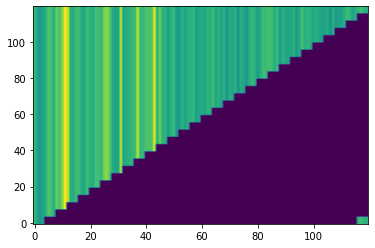

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(odtw.dist_matrix.T, aspect='auto', origin='lower')


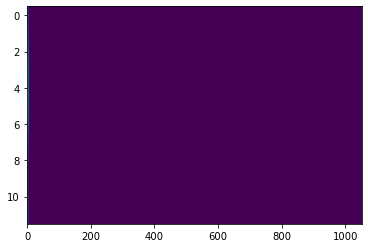

In [15]:
plt.imshow(odtw.query_stft[:,:odtw.ref_pointer], aspect='auto')

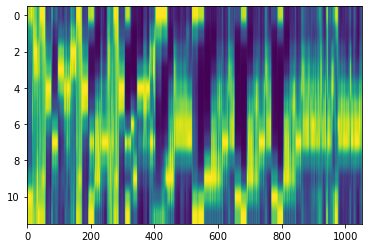

In [16]:
plt.imshow(odtw.ref_stft, aspect='auto')